In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from LossLandscape_helper_functions import *

SEED = 2022

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Random seed 2022 has been set.
Device: cpu


# Train narrow linear NN (in->h->out) with backprop

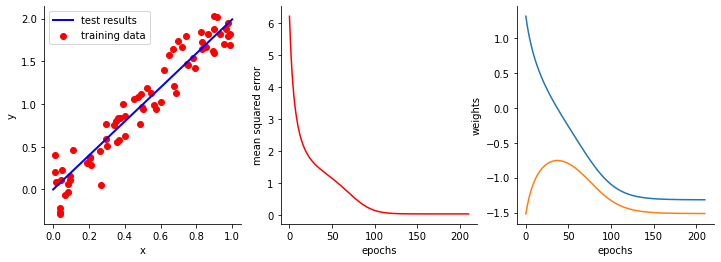

In [18]:
class ShallowNarrowNet:
    """
    Shallow and narrow (one neuron per layer) linear neural network
    """

    def __init__(self, init_weights):
        """
        Initialize parameters of ShallowNarrow Net

        Args:
          init_weights: list
            Initial weights

        Returns:
          Nothing
        """
        assert isinstance(init_weights, (list, np.ndarray, tuple))
        assert len(init_weights) == 2
        self.w1 = init_weights[0]
        self.w2 = init_weights[1]


    def forward(self, x):
        """
        The forward pass through netwrok y = x * w1 * w2

        Args:
          x: np.ndarray
            Features (inputs) to neural net

        Returns:
          y: np.ndarray
            Neural network output (predictions)
        """
        y = x * self.w1 * self.w2
        return y


    def dloss_dw(self, x, y_true):
        """
        Gradient of loss with respect to weights

        Args:
          x: np.ndarray
            Features (inputs) to neural net
          y_true: np.ndarray
            True labels

        Returns:
          dloss_dw1: float
            Mean gradient of loss with respect to w1
          dloss_dw2: float
            Mean gradient of loss with respect to w2
        """
        assert x.shape == y_true.shape
        dloss_dw1 = - (2 * self.w2 * x * (y_true - self.w1 * self.w2 * x)).mean()
        dloss_dw2 = - (2 * self.w1 * x * (y_true - self.w1 * self.w2 * x)).mean()
        return dloss_dw1, dloss_dw2


    def train(self, x, y_true, lr, n_ep):
        """
        Training with Gradient descent algorithm

        Args:
          x: np.ndarray
            Features (inputs) to neural net
          y_true: np.ndarray
            True labels
          lr: float
            Learning rate
          n_ep: int
            Number of epochs (training iterations)

        Returns:
          loss_records: list
            Training loss records
          weight_records: list
            Training weight records (evolution of weights)
        """
        assert x.shape == y_true.shape

        loss_records = np.empty(n_ep)  # Pre allocation of loss records
        weight_records = np.empty((n_ep, 2))  # Pre allocation of weight records

        for i in range(n_ep):
            y_prediction = self.forward(x)
            loss_records[i] = loss(y_prediction, y_true)
            dloss_dw1, dloss_dw2 = self.dloss_dw(x, y_true)
            self.w1 -= lr * dloss_dw1
            self.w2 -= lr * dloss_dw2
            weight_records[i] = [self.w1, self.w2]

        return loss_records, weight_records


def loss(y_prediction, y_true):
    """
    Mean squared error

    Args:
    y_prediction: np.ndarray
      Model output (prediction)
    y_true: np.ndarray
      True label

    Returns:
    mse: np.ndarray
      Mean squared error loss
    """
    assert y_prediction.shape == y_true.shape
    mse = ((y_true - y_prediction)**2).mean()
    return mse

set_seed(seed=SEED)
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)
## Uncomment to run
sn_model = ShallowNarrowNet(initial_weights)
loss_log, weight_log = sn_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval = sn_model.forward(x_eval)

plot_x_y_(x_train, y_train, x_eval, y_eval, loss_log, weight_log)

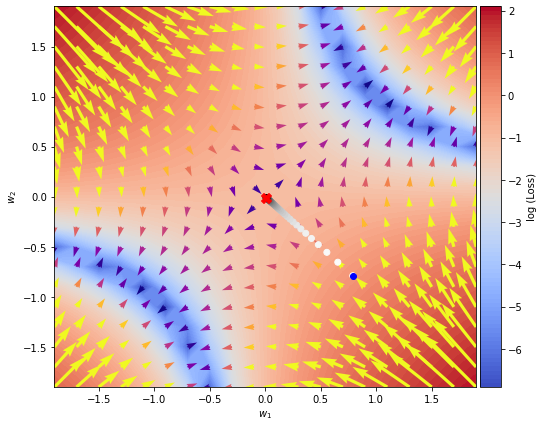

In [3]:
plot_vector_field('all', [1.0, -1.0])

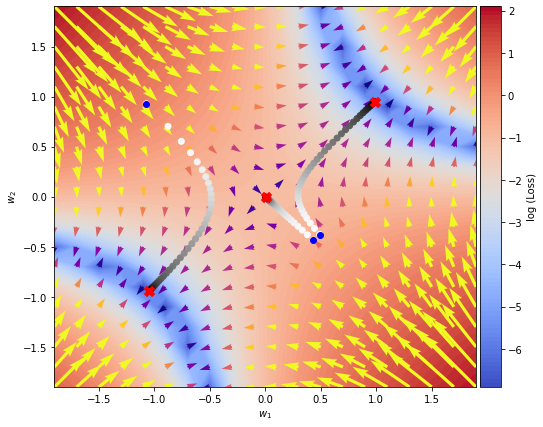

In [4]:
plot_vector_field('all')

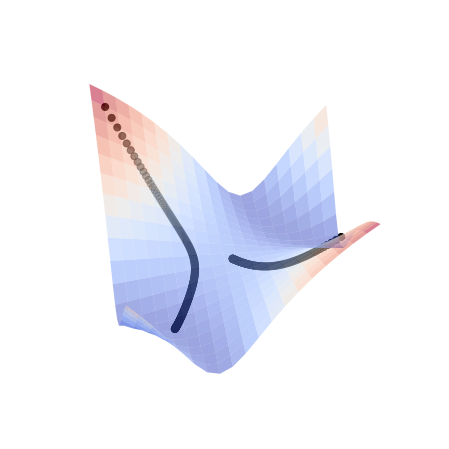

In [5]:
plot_loss_landscape()

# Training the same "network" with BTSP

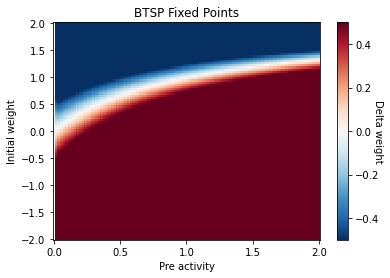

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import stats


def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]

tweaked_sigmoid = scaled_single_sigmoid(0.01, 0.02)
def btsp_rule(Pre, Mod, W, Wmax=2., k_pot=1, k_dep=1, k_decay=0.3, weight_decay=False):
    if weight_decay:
        dW = k_pot*(Wmax - W)*Pre*Mod - k_dep*W*tweaked_sigmoid(Pre * Mod) - (k_decay * Pre)# * post)
    else:
        dW = k_pot*(Wmax - W)*Pre*Mod - k_dep*W*tweaked_sigmoid(Pre * Mod)
#     else:
#         out = k_pot*(I*Wmax - W)*E - I*k_dep*W*tweaked_sigmoid(E*I)
    return dW


learning_rate = 0.25
input_peak_rate = 2.0

pre = np.linspace(0., input_peak_rate, 100)
# w0 = np.linspace(0., max_weight_scale, 100)

# pre = np.linspace(-input_peak_rate, input_peak_rate, 100)
w0 = np.linspace(-2, 2, 100)

pre_mesh, w0_mesh = np.meshgrid(pre, w0)
plt.figure()
plt.pcolormesh(pre_mesh, w0_mesh,
               btsp_rule(pre_mesh, Mod=1, W=w0_mesh),
               cmap='RdBu_r', shading='nearest',
               vmin=-2 * learning_rate, vmax=2 * .25)
plt.xlabel('Pre activity')
plt.ylabel('Initial weight')
cbar = plt.colorbar()
cbar.set_label('Delta weight', rotation=-90.)
plt.title('BTSP Fixed Points')
plt.show()

Random seed 2022 has been set.


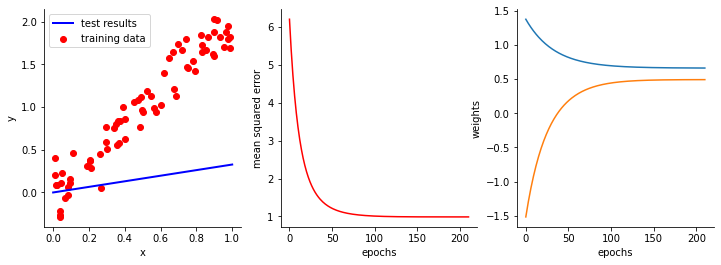

In [77]:
class batchBTSP_rate_net:
    '''
    Linear NN with 1 input, 1 hidden, 1 output (i.e. 2 weights)
    '''
    def __init__(self, init_weights):
        self.w1 = init_weights[0]
        self.w2 = init_weights[1]
        
        
    def forward(self, x):
        h = x * self.w1 #hidden unit activity
        y = h * self.w2 #output unit activity
        return y, h
    
    
    def compute_mod(self, y_prediction, y_true):
        error = y_true - y_prediction
        mean_error = np.mean(y_true - y_prediction)

        threshold = 0.2
        if mean_error > threshold:
            mod = 1
        else:
            mod = 0

        return mod
            
        
    def train(self, x, y_true, lr, n_ep):
        loss_history = np.empty(n_ep)  # Pre allocation of loss records
        mod_history = np.empty(n_ep)  # Pre allocation of loss records
        weight_history = np.empty((n_ep, 2))  # Pre allocation of weight records

        for i in range(n_ep):
            y_prediction, hidden = self.forward(x)
            mod = self.compute_mod(y_prediction, y_true)
            
            dw1 = btsp_rule(Pre=np.mean(x), Mod=mod, W=self.w1)
            dw2 = btsp_rule(Pre=np.mean(hidden), Mod=mod, W=self.w2)
            
            self.w1 += lr * dw1
            self.w2 += lr * dw2
            
            mse_loss = np.mean((y_true - y_prediction)**2)
            loss_history[i] = mse_loss
            mod_history[i] = mod
            weight_history[i] = [self.w1, self.w2]

        return loss_history, mod_history, weight_history

set_seed(seed=SEED) 
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

BTSP_model = batchBTSP_rate_net(initial_weights)
loss_history, mod_history, weight_history = BTSP_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval,hidden_eval = BTSP_model.forward(x_eval)

# print(x_train.shape,y_train.shape, x_eval.shape,y_eval.shape,mod_history.shape,weight_history.shape)
plot_x_y_(x_train, y_train, x_eval, y_eval, loss_history, weight_history)

Random seed 2022 has been set.


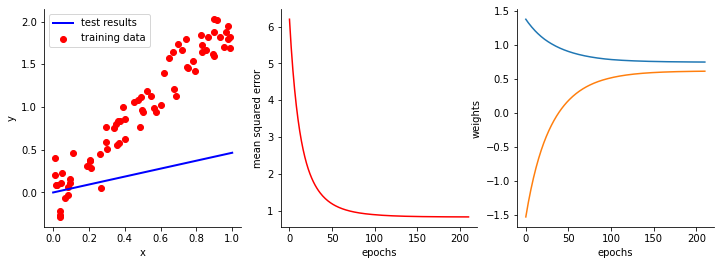

In [75]:
class batchBTSP_rate_net2:
    '''
    Linear NN with 1 input, 1 hidden, 1 output (i.e. 2 weights)
    '''
    def __init__(self, init_weights):
        self.w1 = init_weights[0]
        self.w2 = init_weights[1]
        
        
    def forward(self, x):
        h = x * self.w1 #hidden unit activity
        y = h * self.w2 #output unit activity
        return y, h
    
    
    def compute_mod(self, y_prediction, y_true):
        error = y_true - y_prediction
        threshold = 0.2
        
        mod = error > threshold
        mod = mod.astype(int)
            
        return mod
            
        
    def train(self, x, y_true, lr, n_ep):
        loss_history = np.empty(n_ep)  # Pre allocation of loss records
        mod_history = np.empty(n_ep)  # Pre allocation of loss records
        weight_history = np.empty((n_ep, 2))  # Pre allocation of weight records

        for i in range(n_ep):
            y_prediction, hidden = self.forward(x)
            mod = self.compute_mod(y_prediction, y_true)
            
            dw1 = btsp_rule(Pre=x, Mod=mod, W=self.w1)
            dw2 = btsp_rule(Pre=hidden, Mod=mod, W=self.w2)
            
            dw1 = np.mean(dw1)
            dw2 = np.mean(dw2)
            
            self.w1 += lr * dw1
            self.w2 += lr * dw2
            
            mse_loss = np.mean((y_true - y_prediction)**2)
            loss_history[i] = mse_loss
            mod_history[i] = np.mean(mod)
            weight_history[i] = [self.w1, self.w2]

        return loss_history, mod_history, weight_history

set_seed(seed=SEED) 
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

BTSP_model = batchBTSP_rate_net2(initial_weights)
loss_history, mod_history, weight_history = BTSP_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval,hidden_eval = BTSP_model.forward(x_eval)

# print(x_train.shape,y_train.shape, x_eval.shape,y_eval.shape,mod_history.shape,weight_history.shape)
plot_x_y_(x_train, y_train, x_eval, y_eval, loss_history, weight_history)

Random seed 2022 has been set.


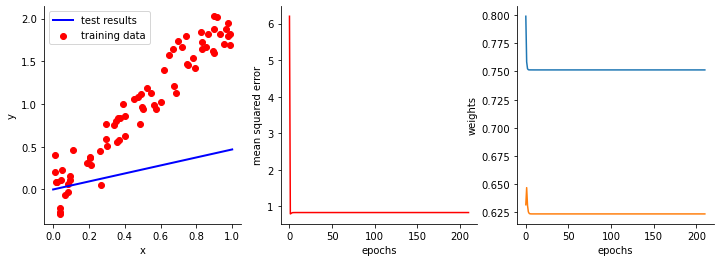

In [79]:
class stochasticBTSP_rate_net:
    '''
    Linear NN with 1 input, 1 hidden, 1 output (i.e. 2 weights)
    '''
    def __init__(self, init_weights):
        self.w1 = init_weights[0]
        self.w2 = init_weights[1]
        
        
    def forward(self, x):
        h = x * self.w1 #hidden unit activity
        y = h * self.w2 #output unit activity
        return y, h
    
    
    def compute_mod(self, y_prediction, y_true):
        error = y_true - y_prediction
        threshold = 0.2
        
        mod = error > threshold
        mod = mod.astype(int)
            
        return mod
            
        
    def train(self, x, y_true, lr, n_ep):
        loss_history = np.empty(n_ep)  # Pre allocation of loss records
        mod_history = np.empty(n_ep)  # Pre allocation of loss records
        weight_history = np.empty((n_ep, 2))  # Pre allocation of weight records

        for i in range(n_ep):
            y_prediction, hidden = self.forward(x)
            mod = self.compute_mod(y_prediction, y_true)
            
            for x_i,h_i,mod_i in zip(x,hidden,mod):
                dw1 = btsp_rule(Pre=x_i, Mod=mod_i, W=self.w1)
                dw2 = btsp_rule(Pre=h_i, Mod=mod_i, W=self.w2)
                
                self.w1 += lr * dw1
                self.w2 += lr * dw2
            
            mse_loss = np.mean((y_true - y_prediction)**2)
            loss_history[i] = mse_loss
            mod_history[i] = np.mean(mod)
            weight_history[i] = [self.w1, self.w2]

        return loss_history, mod_history, weight_history

set_seed(seed=SEED) 
n_epochs = 211
learning_rate = 0.02
initial_weights = [1.4, -1.6]
x_train, y_train = gen_samples(n=73, a=2.0, sigma=0.2)
x_eval = np.linspace(0.0, 1.0, 37, endpoint=True)

BTSP_model = stochasticBTSP_rate_net(initial_weights)
loss_history, mod_history, weight_history = BTSP_model.train(x_train, y_train, learning_rate, n_epochs)
y_eval,hidden_eval = BTSP_model.forward(x_eval)

# print(x_train.shape,y_train.shape, x_eval.shape,y_eval.shape,mod_history.shape,weight_history.shape)
plot_x_y_(x_train, y_train, x_eval, y_eval, loss_history, weight_history)